In [ ]:
import pickle
import pprint
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings('ignore')

# eda

In [111]:
datapath = 'diabetes_user_profiles_with_mealID.csv'
df = pd.read_csv(datapath)
df

,RecordID,Name,Age,Gender,Height,Weight,Location,Occupation,DiabetesType,DiagnosedYearsAgo,...,DietFollowed,TriggerFoods,Allergies,Intolerances,HealthGoals,DietChallenges,TraditionalFoods,CookingFrequency,CookingMethods,MealID
0,1,Nimal Fernando,64,Male,168,80,Jaffna,Homemaker,Gestational,2,...,Vegetarian,NaN,Dairy,Gluten,Better blood sugar control,Cravings,Pickled vegetables,Rarely,Steaming,4
1,2,Kumari Rathnayake,55,Female,178,96,Kandy,Office worker,Type 1,14,...,Low-carb,Sugary snacks,Nuts,Gluten,Better blood sugar control,Cravings,Pickled vegetables,Daily,Slow cooking,4
2,3,Anjali Perera,57,Female,180,55,Jaffna,Homemaker,Type 1,10,...,NaN,Sugary snacks,Dairy,Lactose,Weight management,Time constraints,Pickled vegetables,Rarely,Boiling,5
3,4,Amara Wijesinghe,48,Female,156,56,Colombo,Office worker,Type 1,4,...,Vegetarian,Sugary snacks,Dairy,NaN,Better blood sugar control,Time constraints,Pickled vegetables,Rarely,Boiling,3
4,5,Kumari Rathnayake,70,Female,175,50,Colombo,Homemaker,Type 2,5,...,Vegetarian,White bread,NaN,Gluten,Better blood sugar control,Cravings,Coconut sambol,Few times a week,Slow cooking,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Amara Wijesinghe,32,Female,179,99,Galle,Teacher,Type 2,1,...,Vegetarian,NaN,Nuts,Gluten,Weight management,Cravings,Coconut sambol,Rarely,Steaming,3
496,497,Anjali Perera,22,Male,161,72,Jaffna,Office worker,Type 1,10,...,Gluten-Free,NaN,Dairy,Gluten,Better blood sugar control,Cost,Kiribath,Few times a week,Steaming,2
497,498,Kumari Rathnayake,36,Male,174,81,Batticaloa,Homemaker,Type 1,11,...,Vegetarian,White bread,Dairy,NaN,Better blood sugar control,Time constraints,Pickled vegetables,Few times a week,Slow cooking,2
498,499,Amara Wijesinghe,21,Female,162,70,Jaffna,Farmer,Gestational,5,...,Vegetarian,White bread,Nuts,Lactose,Weight management,Cost,Coconut sambol,Daily,Boiling,1


In [ ]:
# sample_json = df.iloc[0].to_json()
# with open('sample.json', 'w') as f:
#     f.write(sample_json)

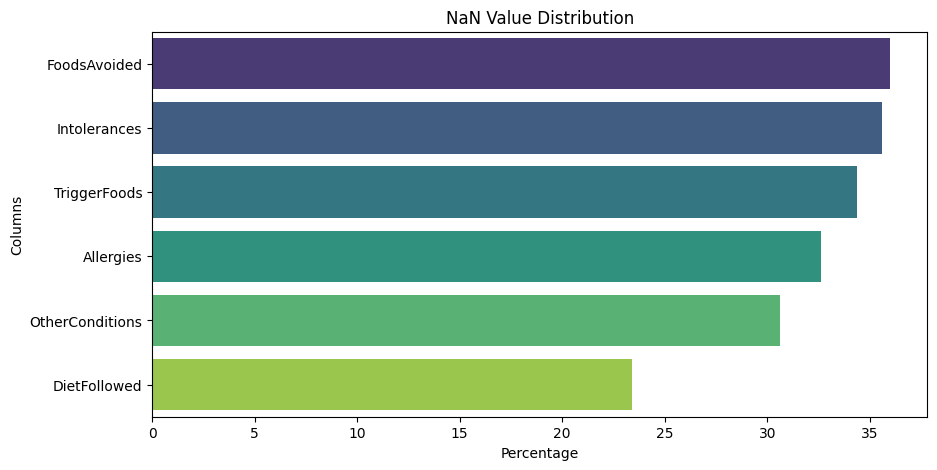

In [74]:
### NaN Value Distribution
nan_dist = df.isna().sum()
nan_dist = nan_dist[nan_dist > 0]
nan_dist = nan_dist.sort_values(ascending=False)
nan_dist = nan_dist / df.shape[0] * 100
nan_dist = nan_dist.round(2)

# plot
plt.figure(figsize=(10, 5))
sns.barplot(x=nan_dist.values, y=nan_dist.index, palette='viridis')
plt.title('NaN Value Distribution')
plt.xlabel('Percentage')
plt.ylabel('Columns')
plt.show()

In [75]:
df.drop(
        columns=[
                'RecordID', 'Name',
                'OtherConditions', 
                'FoodsAvoided', 
                'Intolerances', 
                'TriggerFoods', 
                'DietFollowed',
                'Allergies'
                ],
        inplace=True
        )
df

,Age,Gender,Height,Weight,Location,Occupation,DiabetesType,DiagnosedYearsAgo,FastingGlucose,PostprandialGlucose,FavoriteFoods,HealthGoals,DietChallenges,TraditionalFoods,CookingFrequency,CookingMethods,MealID
0,64,Male,168,80,Jaffna,Homemaker,Gestational,2,138,235,Rice and curry,Better blood sugar control,Cravings,Pickled vegetables,Rarely,Steaming,4
1,55,Female,178,96,Kandy,Office worker,Type 1,14,120,146,Rice and curry,Better blood sugar control,Cravings,Pickled vegetables,Daily,Slow cooking,4
2,57,Female,180,55,Jaffna,Homemaker,Type 1,10,122,217,Rice and curry,Weight management,Time constraints,Pickled vegetables,Rarely,Boiling,5
3,48,Female,156,56,Colombo,Office worker,Type 1,4,101,160,String hoppers,Better blood sugar control,Time constraints,Pickled vegetables,Rarely,Boiling,3
4,70,Female,175,50,Colombo,Homemaker,Type 2,5,143,179,String hoppers,Better blood sugar control,Cravings,Coconut sambol,Few times a week,Slow cooking,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,32,Female,179,99,Galle,Teacher,Type 2,1,142,249,Fruit salad,Weight management,Cravings,Coconut sambol,Rarely,Steaming,3
496,22,Male,161,72,Jaffna,Office worker,Type 1,10,132,206,String hoppers,Better blood sugar control,Cost,Kiribath,Few times a week,Steaming,2
497,36,Male,174,81,Batticaloa,Homemaker,Type 1,11,130,184,Rice and curry,Better blood sugar control,Time constraints,Pickled vegetables,Few times a week,Slow cooking,2
498,21,Female,162,70,Jaffna,Farmer,Gestational,5,94,209,Rice and curry,Weight management,Cost,Coconut sambol,Daily,Boiling,1


In [76]:
output_column = ['MealID']
cat_columns = ['Gender', 'Location', 'Occupation', 'DiabetesType', 'FavoriteFoods', 'HealthGoals', 'DietChallenges', 'TraditionalFoods', 'CookingFrequency', 'CookingMethods']
num_columns = ['Age', 'Height', 'Weight', 'DiagnosedYearsAgo', 'FastingGlucose', 'PostprandialGlucose']

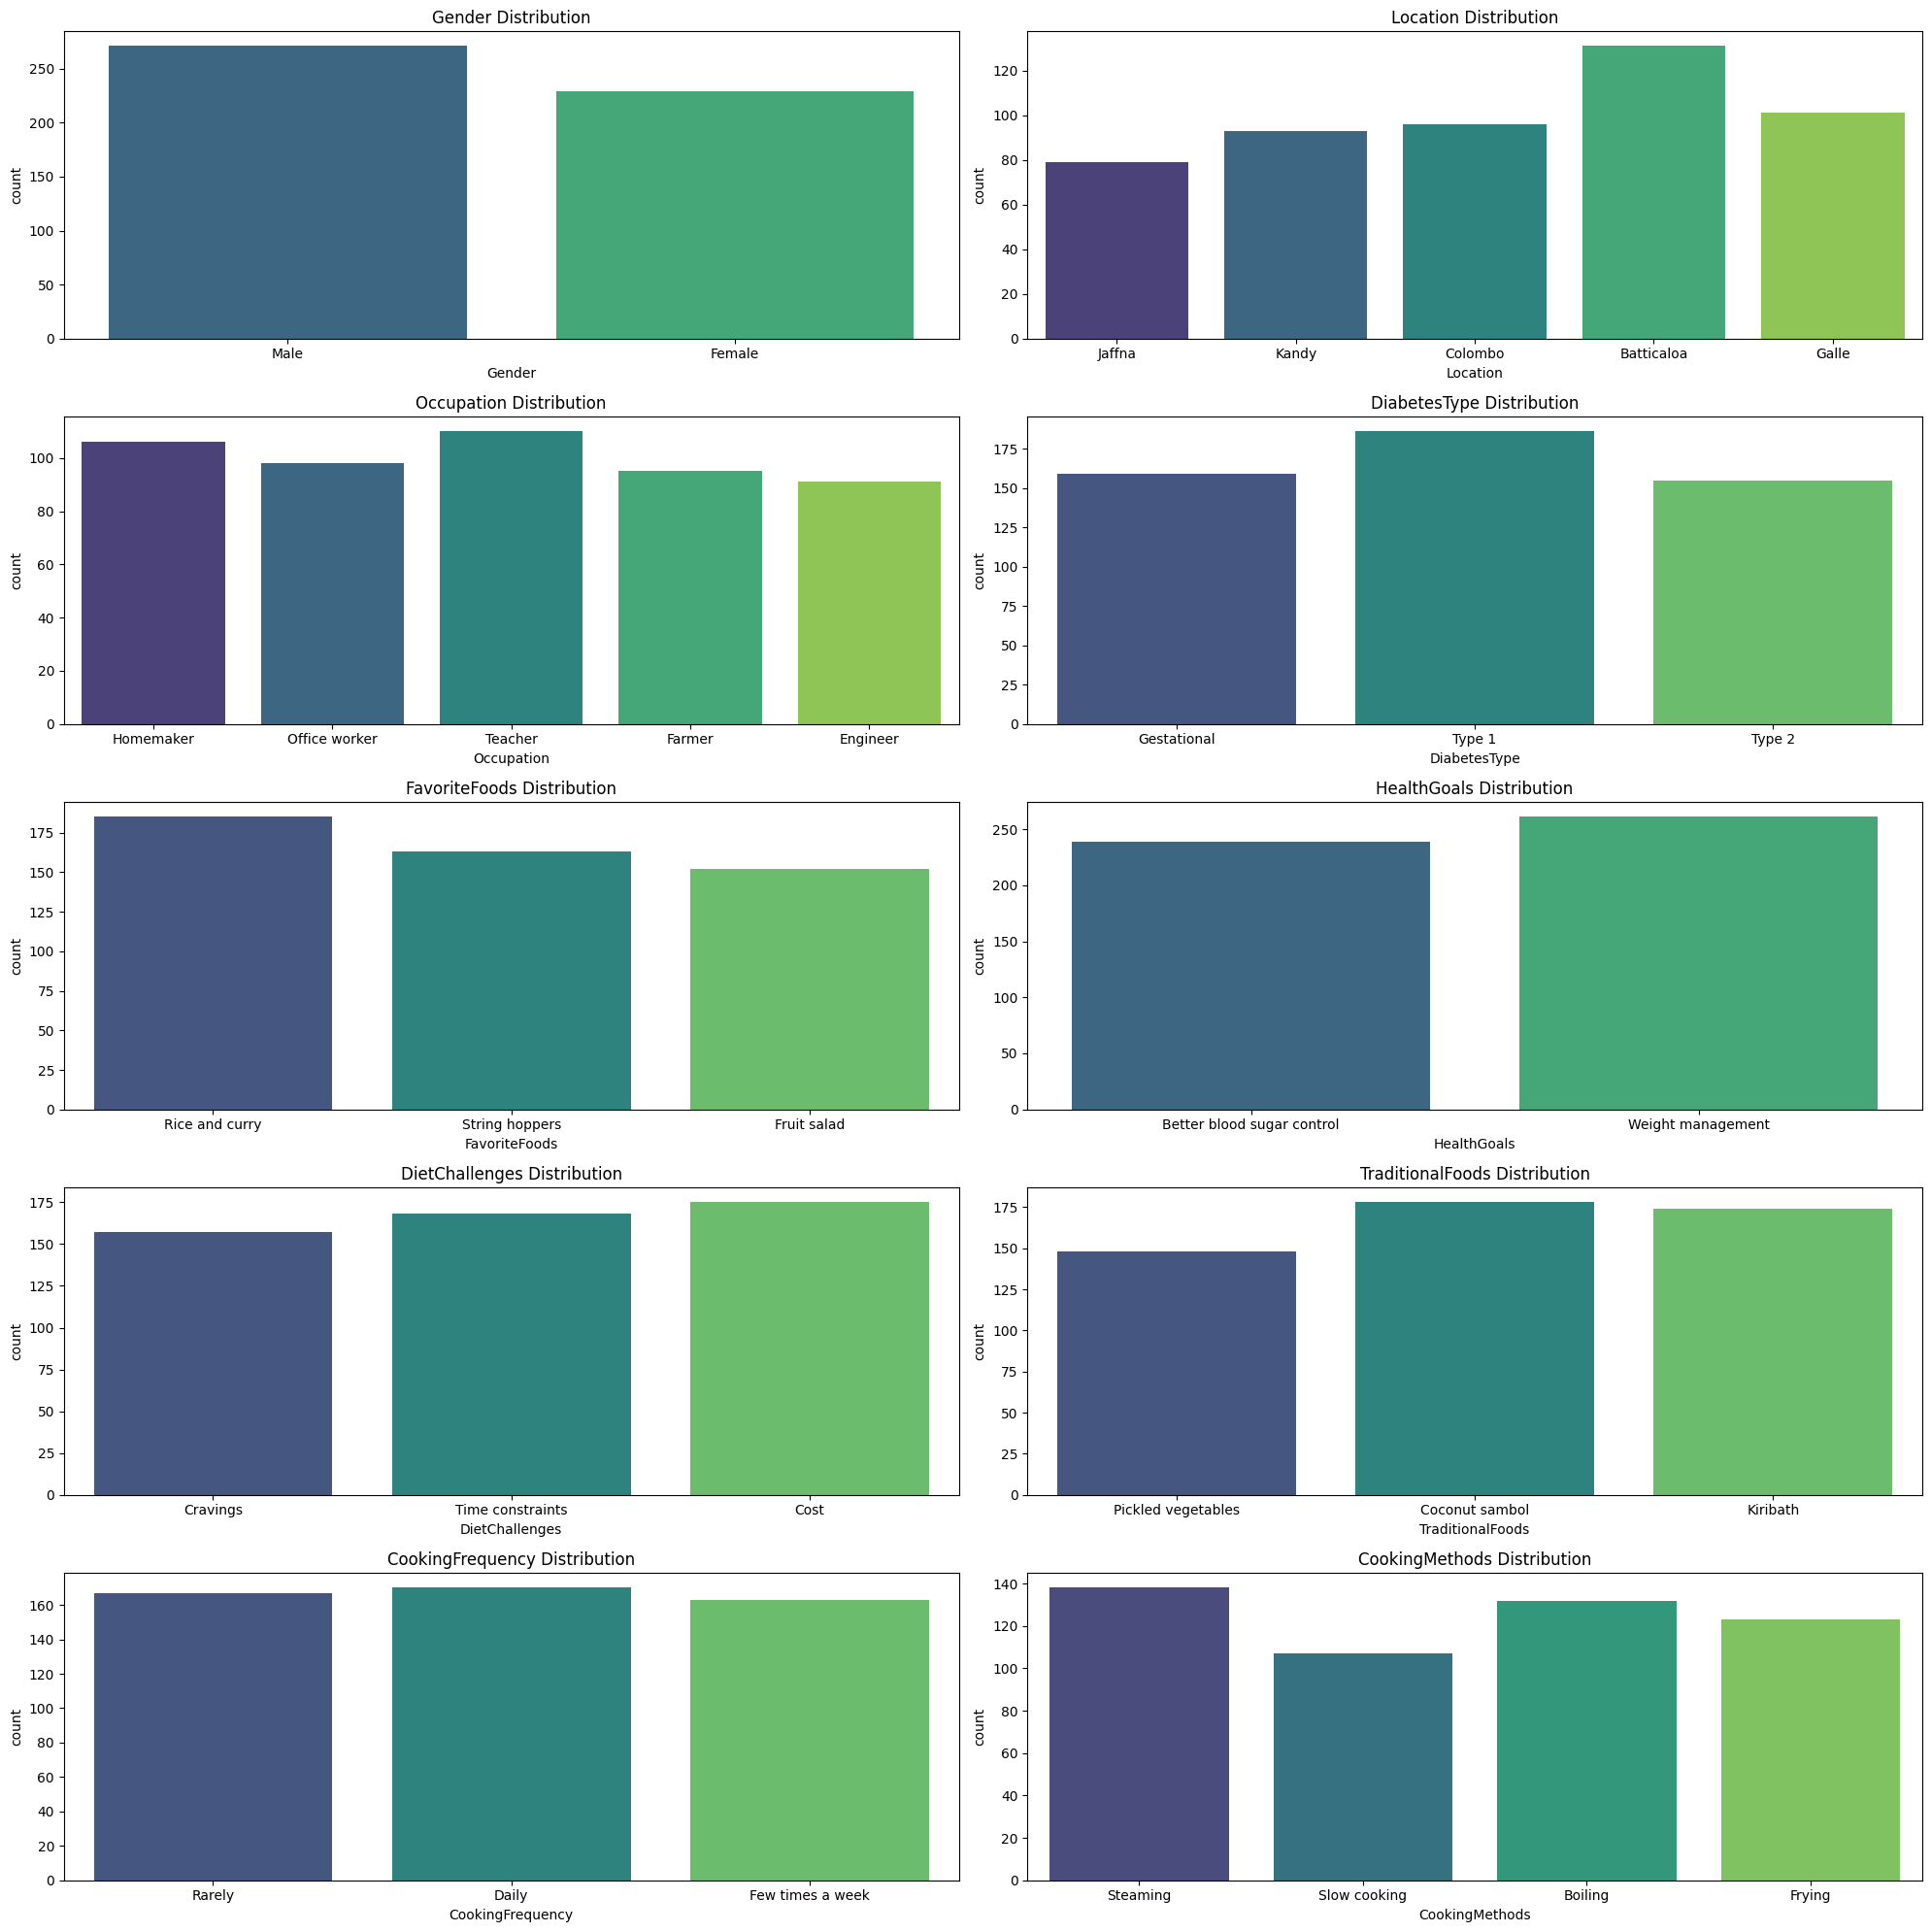

In [77]:
## plot cat column distribution 5 x 2
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
for i, column in enumerate(cat_columns):
    sns.countplot(x=column, data=df, ax=axes[i//2, i%2], palette='viridis')
    axes[i//2, i%2].set_title(f'{column} Distribution')
    axes[i//2, i%2].set_xlabel(column)

plt.tight_layout()
plt.show()

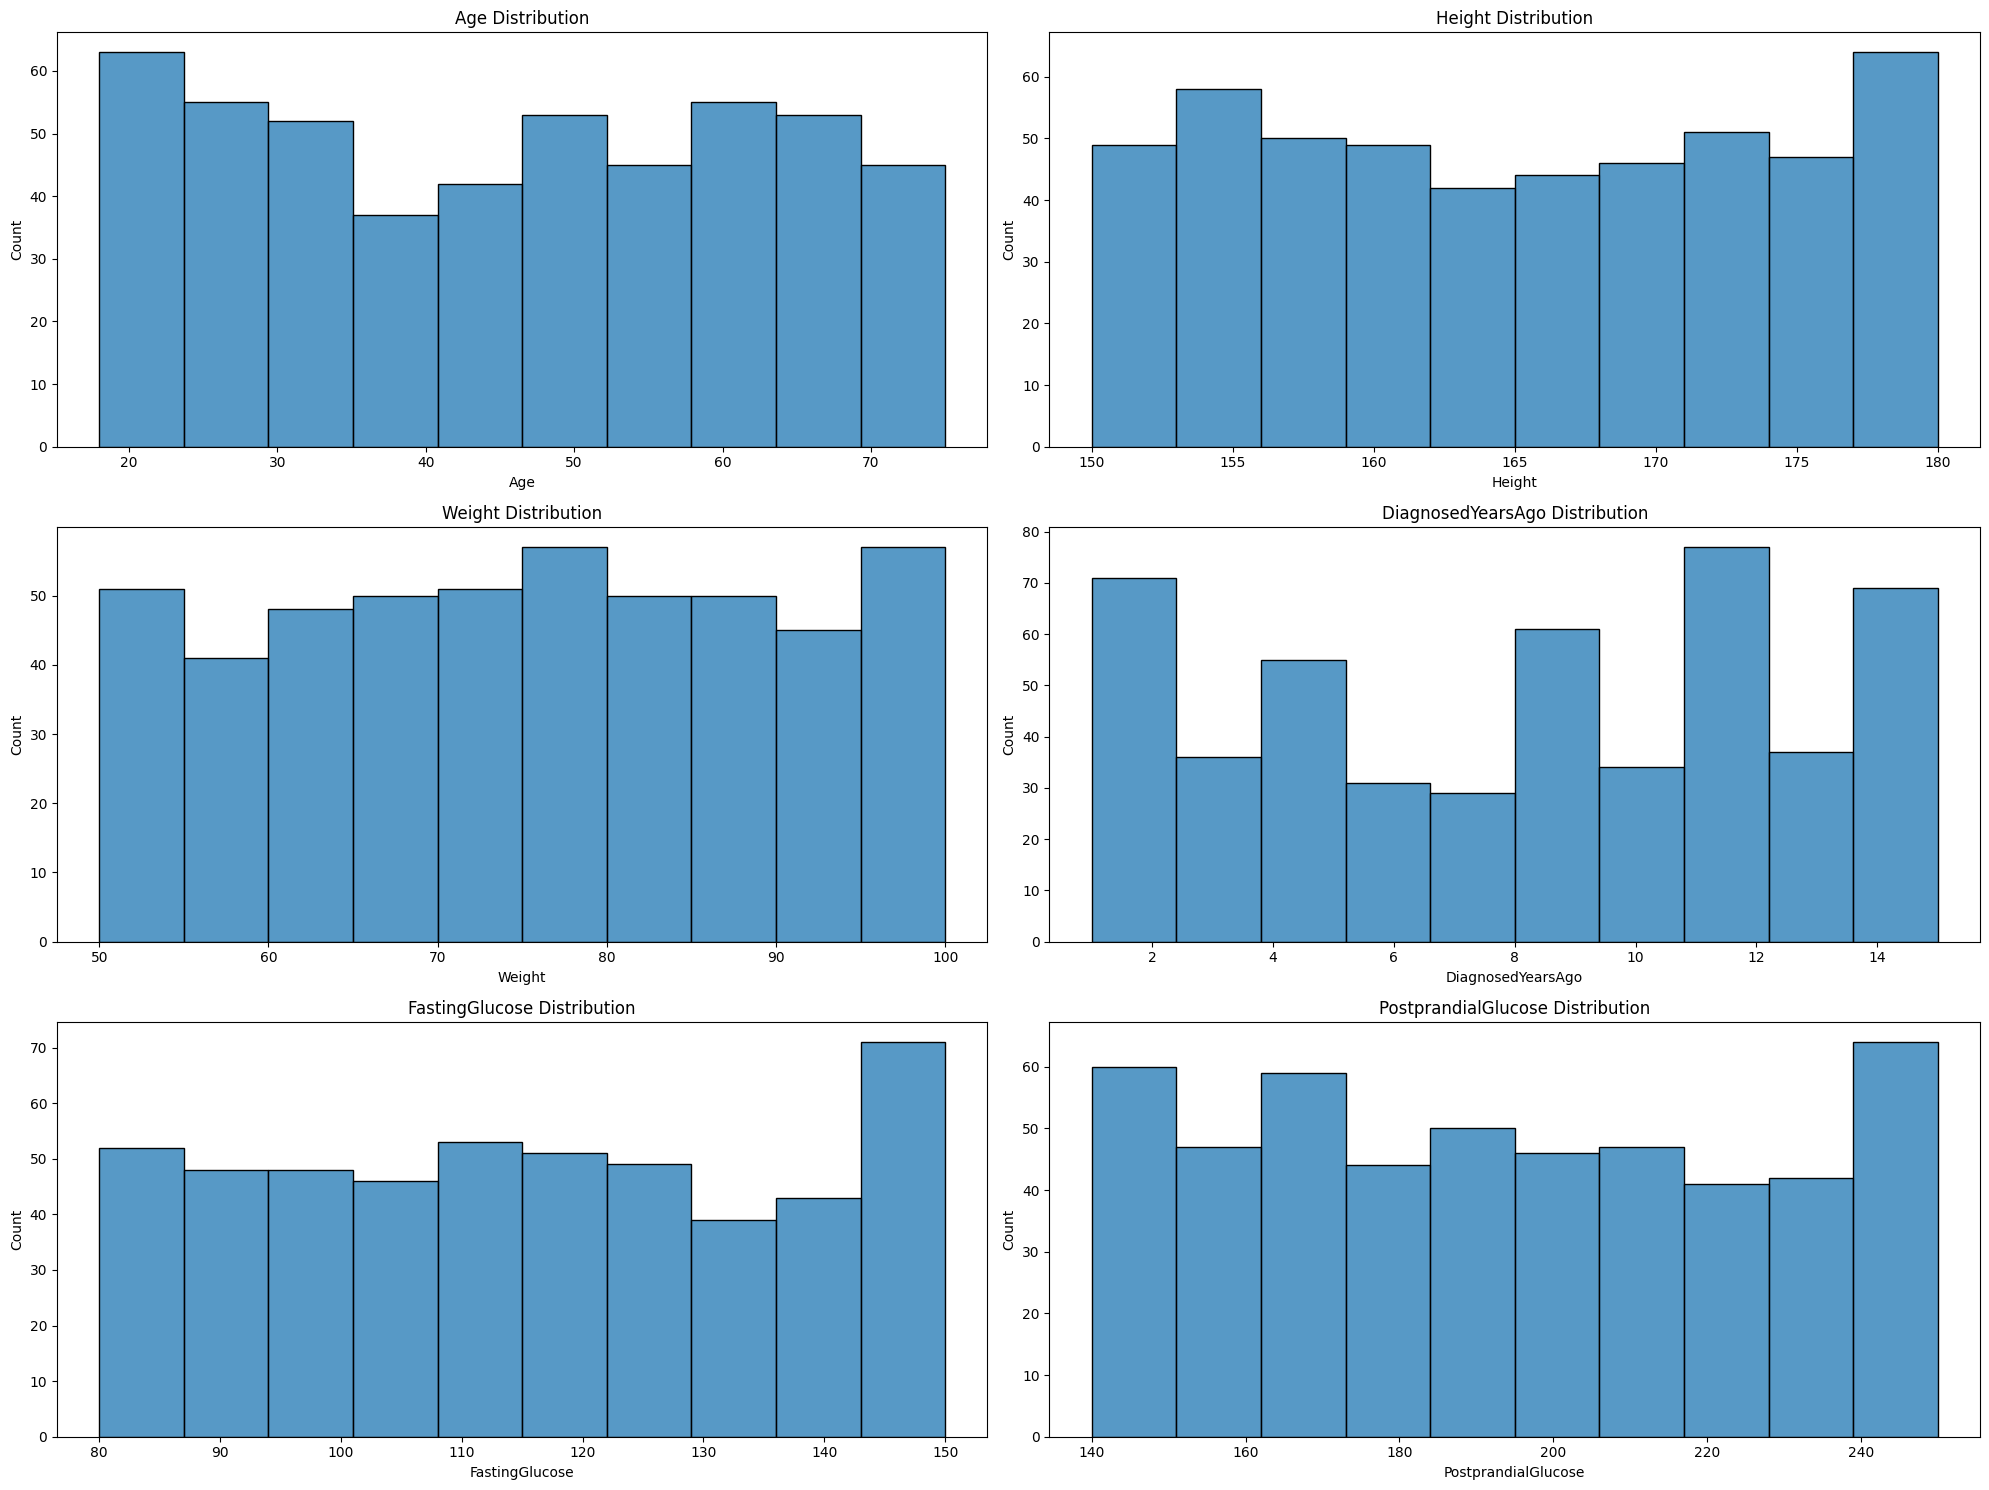

In [78]:
## plot num column distribution 3 x 2
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
for i, column in enumerate(num_columns):
    sns.histplot(df[column], ax=axes[i//2, i%2], palette='viridis')
    axes[i//2, i%2].set_title(f'{column} Distribution')
    axes[i//2, i%2].set_xlabel(column)

plt.tight_layout()
plt.show()

In [93]:
def data_pipeline(
                    datapath = 'diabetes_user_profiles_with_mealID.csv',
                    cat_columns = ['Gender', 'Location', 'Occupation', 'DiabetesType', 'FavoriteFoods', 'HealthGoals', 'DietChallenges', 'TraditionalFoods', 'CookingFrequency', 'CookingMethods'],
                    num_columns = ['Age', 'Height', 'Weight', 'DiagnosedYearsAgo', 'FastingGlucose', 'PostprandialGlucose'],
                    output_column = ['MealID']
                    ):
    df = pd.read_csv(datapath)
    df.drop(
            columns=[
                    'RecordID', 'Name',
                    'OtherConditions', 
                    'FoodsAvoided', 
                    'Intolerances', 
                    'TriggerFoods', 
                    'DietFollowed',
                    'Allergies'
                    ],
            inplace=True
            )

    encoder = defaultdict(LabelEncoder)
    for col in cat_columns + output_column:
        encoder[col].fit(df[col])
        df[col] = encoder[col].transform(df[col])

    with open('encoder_meal.pkl', 'wb') as f:
        pickle.dump(encoder, f)

    X = df.drop(columns = cat_columns + output_column)
    Y = df[output_column]

    X, Y = np.array(X), np.array(Y).ravel()
    return X, Y, encoder

In [94]:
X, Y, encoder_meal = data_pipeline()

X_train, X_test, Y_train, Y_test = train_test_split(
                                                    X, Y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                    )

print(f"\nX_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")


X_train shape: (400, 6)
Y_train shape: (400,)
X_test shape: (100, 6)
Y_test shape: (100,)


In [95]:
cat = CatBoostClassifier(
                        iterations=1000, 
                        learning_rate=0.1, 
                        loss_function='MultiClass', 
                        depth=6
                        )
cat.fit(
        X, Y, 
        eval_set=(
                    X_test, 
                    Y_test
                ), 
        verbose=100
        )

0:	learn: 1.5930468	test: 1.5937598	best: 1.5937598 (0)	total: 1.97ms	remaining: 1.97s
100:	learn: 0.9514731	test: 0.9540896	best: 0.9540896 (100)	total: 167ms	remaining: 1.49s
200:	learn: 0.6034865	test: 0.6000761	best: 0.6000761 (200)	total: 326ms	remaining: 1.3s
300:	learn: 0.4186140	test: 0.4230262	best: 0.4230262 (300)	total: 486ms	remaining: 1.13s
400:	learn: 0.3046531	test: 0.3047616	best: 0.3047616 (400)	total: 648ms	remaining: 968ms
500:	learn: 0.2314614	test: 0.2323476	best: 0.2323476 (500)	total: 809ms	remaining: 806ms
600:	learn: 0.1839381	test: 0.1840617	best: 0.1840617 (600)	total: 967ms	remaining: 642ms
700:	learn: 0.1492005	test: 0.1497740	best: 0.1497740 (700)	total: 1.13s	remaining: 481ms
800:	learn: 0.1237093	test: 0.1237321	best: 0.1237321 (800)	total: 1.29s	remaining: 321ms
900:	learn: 0.1049651	test: 0.1051141	best: 0.1051141 (900)	total: 1.46s	remaining: 160ms
999:	learn: 0.0906818	test: 0.0900639	best: 0.0900639 (999)	total: 1.62s	remaining: 0us

bestTest = 0.09

In [96]:
with open('model_meal.pkl', 'wb') as f:
    pickle.dump(cat, f)

In [97]:
P_train = cat.predict(X_train)
P_test = cat.predict(X_test)

In [102]:
print("---------------------- Train CLS REPORT ----------------------")
target_names = encoder_meal['MealID'].classes_
target_names = [f'Meal ID : {name}' for name in target_names]
clf_report = classification_report(
                                Y_train,
                                P_train,
                                target_names = target_names
                )
print(clf_report)

print("---------------------- Test CLS REPORT ----------------------")
clf_report = classification_report(
                                Y_test, 
                                P_test,
                                target_names = target_names
                                )
print(clf_report)

---------------------- Train CLS REPORT ----------------------
              precision    recall  f1-score   support

 Meal ID : 1       1.00      1.00      1.00        76
 Meal ID : 2       1.00      1.00      1.00        96
 Meal ID : 3       1.00      1.00      1.00        72
 Meal ID : 4       1.00      1.00      1.00        81
 Meal ID : 5       1.00      1.00      1.00        75

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

---------------------- Test CLS REPORT ----------------------
              precision    recall  f1-score   support

 Meal ID : 1       1.00      1.00      1.00        22
 Meal ID : 2       1.00      1.00      1.00        20
 Meal ID : 3       1.00      1.00      1.00        26
 Meal ID : 4       1.00      1.00      1.00        16
 Meal ID : 5       1.00      1.00      1.00        16

    accuracy                           1.00       100
   mac

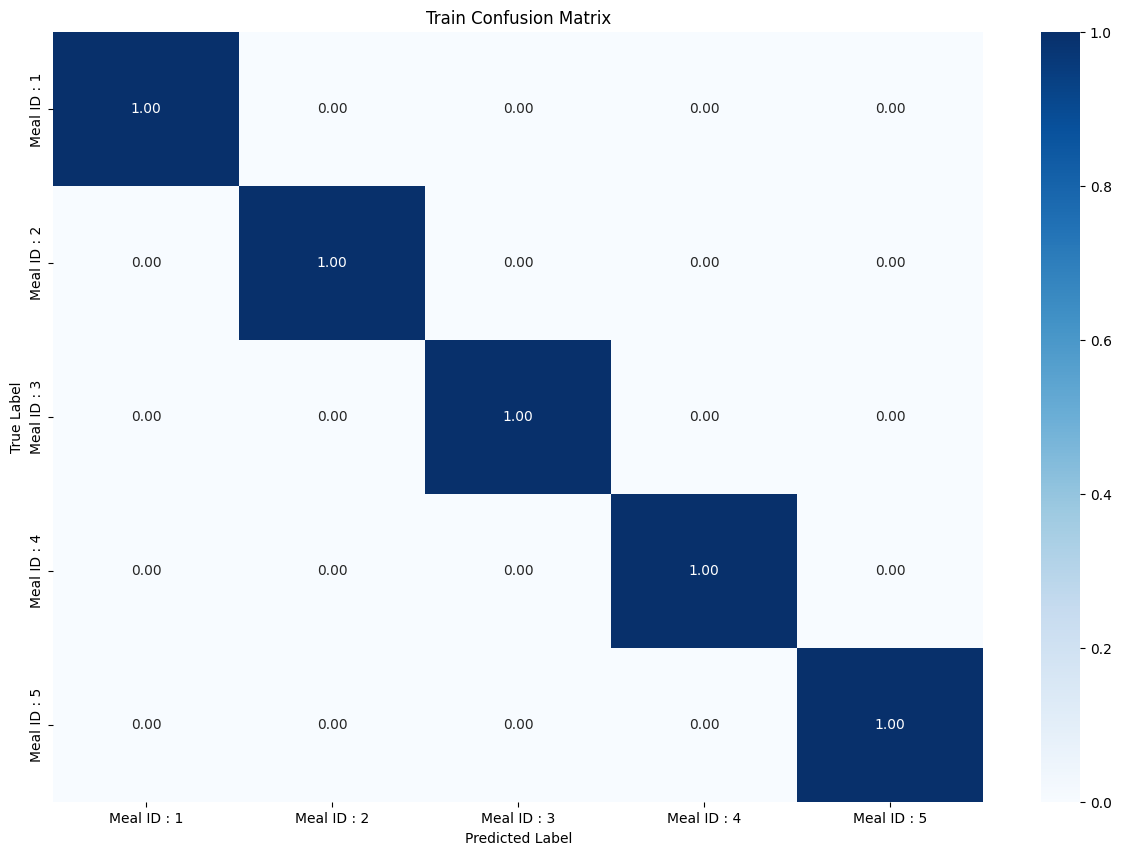

In [107]:
cm = confusion_matrix(Y_train,P_train)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.round(cm, 2)

plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

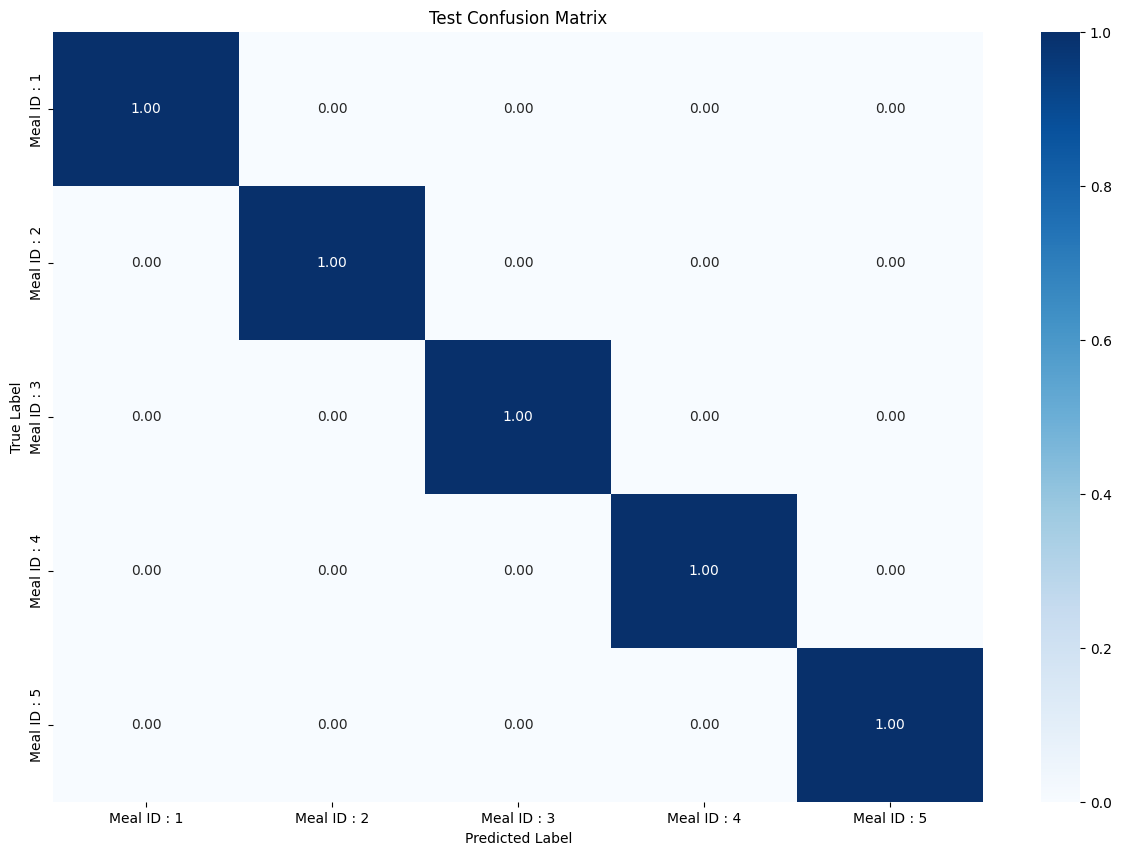

In [108]:
cm = confusion_matrix(Y_test,P_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.round(cm, 2)

plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

### Inference

In [110]:
with open('encoder_meal.pkl', 'rb') as f:
    encoder_meal = pickle.load(f)

with open('model_meal.pkl', 'rb') as f:
    model_meal = pickle.load(f)

In [137]:
def inference_meal(
                    sample_json,
                    meal_path = 'sri_lankan_meal_dataset.csv',
                    cat_columns = ['Gender', 'Location', 'Occupation', 'DiabetesType', 'FavoriteFoods', 'HealthGoals', 'DietChallenges', 'TraditionalFoods', 'CookingFrequency', 'CookingMethods']
                    ):
    df = pd.DataFrame([sample_json])
    df.drop(
        columns=[
                'RecordID', 'Name',
                'OtherConditions', 
                'FoodsAvoided', 
                'Intolerances', 
                'TriggerFoods', 
                'DietFollowed',
                'Allergies'
                ],
        inplace=True
    )

    for col in cat_columns:
        df[col] = encoder_meal[col].transform(df[col])

    x = df.values
    p = model_meal.predict(x)
    p = int(p.squeeze())
    p = encoder_meal['MealID'].inverse_transform([p])[0]
    
    df_meal = pd.read_csv(meal_path)
    df_meal = df_meal[df_meal['MealID'] == p]
    del df_meal['MealID']

    meal_dict = df_meal.to_dict(orient='records')
    
    response = {}
    response['MealID'] = p
    response['Meal'] = meal_dict
    return response
    

In [ ]:
sample_json = {
            "RecordID":1,
            "Name":"Nimal Fernando",
            "Age":64,
            "Gender":"Male",
            "Height":168,
            "Weight":80,
            "Location":"Jaffna",
            "Occupation":"Homemaker",
            "DiabetesType":"Gestational",
            "DiagnosedYearsAgo":2,
            "FastingGlucose":138,
            "PostprandialGlucose":235,
            "OtherConditions":"High cholesterol",
            "FavoriteFoods":"Rice and curry",
            "FoodsAvoided":None,
            "DietFollowed":"Vegetarian",
            "TriggerFoods":None,
            "Allergies":"Dairy",
            "Intolerances":"Gluten",
            "HealthGoals":"Better blood sugar control",
            "DietChallenges":"Cravings",
            "TraditionalFoods":"Pickled vegetables",
            "CookingFrequency":"Rarely",
            "CookingMethods":"Steaming"
            }

In [139]:
df_meal = inference_meal(sample_json)
pprint.pprint(df_meal)

{'Meal': [{'AllergyStatus': 'Contains coconut',
           'CalorieCount': 300,
           'MealDetails': 'Hoppers, lunu miris, dhal curry',
           'MealName': 'Spicy Breakfast',
           'Preferences': 'Vegetarian',
           'Type': 'Breakfast'},
          {'AllergyStatus': 'Contains fish',
           'CalorieCount': 550,
           'MealDetails': 'Red rice, fish curry, beetroot salad',
           'MealName': 'Fish Curry Lunch',
           'Preferences': 'Non-Vegetarian',
           'Type': 'Lunch'},
          {'AllergyStatus': 'Contains gluten',
           'CalorieCount': 300,
           'MealDetails': 'Red lentil soup, whole grain bread',
           'MealName': 'Lentil Soup Dinner',
           'Preferences': 'Vegetarian',
           'Type': 'Dinner'}],
 'MealID': 4}
